In [2]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as st
import wbgapi as wb
import pandas_datareader.data as web

from matplotlib.font_manager import FontManager, FontProperties

# 设置全局字体为中文字体
font_path = '/System/Library/Fonts/PingFang.ttc'
font_prop = FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

In [4]:
# Set graphical parameters
cycler = plt.cycler(
    linestyle=['-', '-.', '--', ':'], 
    color=['#377eb8', '#ff7f00', '#4daf4a', '#ff334f']
)
plt.rc('axes', prop_cycle=cycler)

In [6]:
wb.series.info(q='GPD growth')

In [40]:
gdp_growth = wb.data.DataFrame('NY.GDP.MKTP.KD.ZG', ['USA', 'ARG', 'GBR', 'GRC', 'JPN', 'CHN'], labels=True)
gdp_growth

,Country,YR1960,YR1961,YR1962,YR1963,YR1964,YR1965,YR1966,YR1967,YR1968,YR1969,YR1970,YR1971,YR1972,YR1973,YR1974,YR1975,YR1976,YR1977,YR1978,YR1979,YR1980,YR1981,YR1982,YR1983,YR1984,YR1985,YR1986,YR1987,YR1988,YR1989,YR1990,YR1991,YR1992,YR1993,YR1994,YR1995,YR1996,YR1997,YR1998,YR1999,YR2000,YR2001,YR2002,YR2003,YR2004,YR2005,YR2006,YR2007,YR2008,YR2009,YR2010,YR2011,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020,YR2021,YR2022
economy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CHN,China,NaN,-27.270000,-5.580000,10.300000,18.180000,16.950000,10.650000,-5.770000,-4.100000,16.940000,19.300000,7.060000,3.810000,7.760000,2.310000,8.720000,-1.570000,7.570000,11.325978,7.591325,7.834145,5.112761,9.017114,10.770203,15.191540,13.430678,8.949962,11.657428,11.222595,4.206334,3.920251,9.262786,14.224530,13.883729,13.036807,10.953954,9.922557,9.236780,7.845952,7.661652,8.490093,8.335733,9.133631,10.038030,10.113621,11.394592,12.720956,14.230861,9.650679,9.398726,10.635871,9.550832,7.863736,7.766150,7.425764,7.041329,6.848762,6.947201,6.749774,5.950501,2.238638,8.447478,2.990805
JPN,Japan,NaN,12.043536,8.908973,8.473642,11.676708,5.819708,10.638562,11.082142,12.882468,12.477895,2.454958,4.698992,8.413547,8.032600,-1.225240,3.091576,3.974984,4.390338,5.271942,5.484042,2.817591,4.260624,3.279743,3.630199,4.410880,5.159808,3.294048,4.648861,6.661637,4.925785,4.840929,3.523357,0.900586,-0.459220,1.083383,2.631000,3.133871,0.981229,-1.270330,-0.333930,2.764648,0.386103,0.041962,1.535125,2.186116,1.803901,1.372350,1.483969,-1.224289,-5.693236,4.097918,0.023810,1.374751,2.005100,0.296206,1.560627,0.753827,1.675332,0.643391,-0.402169,-4.278604,2.142487,1.028625
GRC,Greece,NaN,13.203841,0.364811,11.844868,9.409677,10.768011,6.494502,5.669485,7.203719,11.563667,8.565248,7.841177,10.160152,8.092379,-6.438241,6.366809,6.851898,2.941002,7.246863,3.282080,0.677131,-1.553721,-1.132647,-1.078623,2.010580,2.509557,0.517660,-2.258863,4.287862,3.800001,0.000000,3.099999,0.700000,-1.600000,2.000000,2.099720,2.862129,4.484199,3.894905,3.072597,3.919771,4.131612,3.922872,5.794531,5.060992,0.599142,5.652434,3.273747,-0.335172,-4.300734,-5.478218,-10.149315,-7.086697,-2.515997,0.475696,-0.196088,-0.487173,1.092149,1.668429,1.884342,-9.004044,8.434426,5.913708
GBR,United Kingdom,NaN,2.677119,1.102910,4.874384,5.533659,2.142177,1.573100,2.786475,5.441083,1.924097,6.680032,3.504717,4.321668,6.523848,-2.484404,-1.473650,2.910266,2.457751,4.204260,3.749017,-2.031368,-0.787744,1.994891,4.221856,2.269105,4.147415,3.150341,5.392738,5.732414,2.577603,0.733756,-1.103122,0.401082,2.489831,3.846009,2.531670,1.907716,4.524067,3.157287,3.014070,4.092653,2.157428,1.770765,3.123053,2.344971,2.668338,2.160405,2.563460,-0.154344,-4.510486,2.430073,1.067611,1.448457,1.819863,3.199703,2.393103,2.165206,2.443570,1.705021,1.604309,-11.030858,7.597471,4.101621
ARG,Argentina,NaN,5.427843,-0.852022,-5.308197,10.130298,10.569433,-0.659726,3.191997,4.822501,9.679526,3.045643,5.658131,1.628417,2.811754,5.533804,-0.028412,-2.018252,6.934148,-4.506125,10.222763,1.518784,-5.189789,-0.735659,4.349093,1.570739,-5.189024,6.153377,2.704869,-1.089933,-7.156950,-2.467214,9.133111,7.937292,8.206979,5.836201,-2.845210,5.526690,8.111047,3.850179,-3.385457,-0.788999,-4.408840,-10.894485,8.837041,9.029573,8.851660,8.047152,9.007651,4.057233,-5.918525,10.125398,6.003952,-1.026420,2.405324,-2.512615,2.731160,-2.080328,2.818503,-2.617396,-2.000861,-9.943235,10.398249,5.243044
USA,United States,NaN,2.300000,6.100000,4.400000,5.800000,6.400000,6.500000,2.500000,4.800000,3.100000,-0.283491,3.293352,5.258907,5.645723,-0.540552,-0.205456,5.388139,4.624153,5.535305,3.166145,-0.256750,2.537719,-1.802887,4.583913,7.236633,4.169656,3.462646,3.459252,4.177061,3.672648,1.885965,-0.108265,3.522441,2.751781,4.028793,2.684217,3.772565,4.447175,4.481394,4.794499,4.077159,0.954339,1.695943,2.796209,3.852553,3.483220,2.782811,2.010508,0.122188,-2.599888,2.708857,1.549895,2.280688,1.841

In [41]:
wb.series.metadata.get('NY.GDP.MKTP.KD.ZG')

Field,Value
Aggregationmethod,Weighted average
Developmentrelevance,"An economy's growth is measured by the change in the volume of its output or in the real incomes of its residents. The 2008 United Nations System of National Accounts (2008 SNA) offers three plausible indicators for calculating growth: the volume of gross domestic product (GDP), real gross domestic income, and real gross national income. The volume of GDP is the sum of value added, measured at constant prices, by households, government, and industries operating in the economy. GDP accounts for all domestic production, regardless of whether the income accrues to domestic or foreign institutions."
IndicatorName,GDP growth (annual %)
License_Type,CC BY-4.0
License_URL,https://datacatalog.worldbank.org/public-licenses#cc-by
Limitationsandexceptions,"Each industry's contribution to growth in the economy's output is measured by growth in the industry's value added. In principle, value added in constant prices can be estimated by measuring the quantity of goods and services produced in a period, valuing them at an agreed set of base year prices, and subtracting the cost of intermediate inputs, also in constant prices. This double-deflation method requires detailed information on the structure of prices of inputs and outputs. In many industries, however, value added is extrapolated from the base year using single volume indexes of outputs or, less commonly, inputs. Particularly in the services industries, including most of government, value added in constant prices is often imputed from labor inputs, such as real wages or number of employees. In the absence of well defined measures of output, measuring the growth of services remains difficult. Moreover, technical progress can lead to improvements in production processes and in the quality of goods and services that, if not properly accounted for, can distort measures of value added and thus of growth. When inputs are used to estimate output, as for nonmarket services, unmeasured technical progress leads to underestimates of the volume of output. Similarly, unmeasured improvements in quality lead to underestimates of the value of output and value added. The result can be underestimates of growth and productivity improvement and overestimates of inflation. Informal economic activities pose a particular measurement problem, especially in developing countries, where much economic activity is unrecorded. A complete picture of the economy requires estimating household outputs produced for home use, sales in informal markets, barter exchanges, and illicit or deliberately unreported activities. The consistency and completeness of such estimates depend on the skill and methods of the compiling statisticians. Rebasing of national accounts can alter the measured growth rate of an economy and lead to breaks in series that affect the consistency of data over time. When countries rebase their national accounts, they update the weights assigned to various components to better reflect current patterns of production or uses of output. The new base year should represent normal operation of the economy - it should be a year without major shocks or distortions. Some developing countries have not rebased their national accounts for many years. Using an old base year can be misleading because implicit price and volume weights become progressively less relevant and useful. To obtain comparable series of constant price data for computing aggregates, the World Bank rescales GDP and value added by industrial origin to a common reference year. Because rescaling changes the implicit weights used in forming regional and income group aggregates, aggregate growth rates are not comparable with those from earlier editions with different base years. Rescaling may result in a discrepancy between the rescaled GDP and the sum of the rescaled components. To avoid distortions in the growth rates, the discrepancy is left unallocated. As a result, the weigh

In [42]:
# Use the series ID retrieved before
gdp_growth = wb.data.DataFrame('NY.GDP.MKTP.KD.ZG', ['USA', 'ARG', 'GBR', 'GRC', 'JPN', 'CHN'], labels=True)
gdp_growth = gdp_growth.set_index('Country')
gdp_growth.columns = gdp_growth.columns.str.replace('YR', '').astype(int)
gdp_growth

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
China,NaN,-27.270000,-5.580000,10.300000,18.180000,16.950000,10.650000,-5.770000,-4.100000,16.940000,19.300000,7.060000,3.810000,7.760000,2.310000,8.720000,-1.570000,7.570000,11.325978,7.591325,7.834145,5.112761,9.017114,10.770203,15.191540,13.430678,8.949962,11.657428,11.222595,4.206334,3.920251,9.262786,14.224530,13.883729,13.036807,10.953954,9.922557,9.236780,7.845952,7.661652,8.490093,8.335733,9.133631,10.038030,10.113621,11.394592,12.720956,14.230861,9.650679,9.398726,10.635871,9.550832,7.863736,7.766150,7.425764,7.041329,6.848762,6.947201,6.749774,5.950501,2.238638,8.447478,2.990805
Japan,NaN,12.043536,8.908973,8.473642,11.676708,5.819708,10.638562,11.082142,12.882468,12.477895,2.454958,4.698992,8.413547,8.032600,-1.225240,3.091576,3.974984,4.390338,5.271942,5.484042,2.817591,4.260624,3.279743,3.630199,4.410880,5.159808,3.294048,4.648861,6.661637,4.925785,4.840929,3.523357,0.900586,-0.459220,1.083383,2.631000,3.133871,0.981229,-1.270330,-0.333930,2.764648,0.386103,0.041962,1.535125,2.186116,1.803901,1.372350,1.483969,-1.224289,-5.693236,4.097918,0.023810,1.374751,2.005100,0.296206,1.560627,0.753827,1.675332,0.643391,-0.402169,-4.278604,2.142487,1.028625
Greece,NaN,13.203841,0.364811,11.844868,9.409677,10.768011,6.494502,5.669485,7.203719,11.563667,8.565248,7.841177,10.160152,8.092379,-6.438241,6.366809,6.851898,2.941002,7.246863,3.282080,0.677131,-1.553721,-1.132647,-1.078623,2.010580,2.509557,0.517660,-2.258863,4.287862,3.800001,0.000000,3.099999,0.700000,-1.600000,2.000000,2.099720,2.862129,4.484199,3.894905,3.072597,3.919771,4.131612,3.922872,5.794531,5.060992,0.599142,5.652434,3.273747,-0.335172,-4.300734,-5.478218,-10.149315,-7.086697,-2.515997,0.475696,-0.196088,-0.487173,1.092149,1.668429,1.884342,-9.004044,8.434426,5.913708
United Kingdom,NaN,2.677119,1.102910,4.874384,5.533659,2.142177,1.573100,2.786475,5.441083,1.924097,6.680032,3.504717,4.321668,6.523848,-2.484404,-1.473650,2.910266,2.457751,4.204260,3.749017,-2.031368,-0.787744,1.994891,4.221856,2.269105,4.147415,3.150341,5.392738,5.732414,2.577603,0.733756,-1.103122,0.401082,2.489831,3.846009,2.531670,1.907716,4.524067,3.157287,3.014070,4.092653,2.157428,1.770765,3.123053,2.344971,2.668338,2.160405,2.563460,-0.154344,-4.510486,2.430073,1.067611,1.448457,1.819863,3.199703,2.393103,2.165206,2.443570,1.705021,1.604309,-11.030858,7.597471,4.101621
Argentina,NaN,5.427843,-0.852022,-5.308197,10.130298,10.569433,-0.659726,3.191997,4.822501,9.679526,3.045643,5.658131,1.628417,2.811754,5.533804,-0.028412,-2.018252,6.934148,-4.506125,10.222763,1.518784,-5.189789,-0.735659,4.349093,1.570739,-5.189024,6.153377,2.704869,-1.089933,-7.156950,-2.467214,9.133111,7.937292,8.206979,5.836201,-2.845210,5.526690,8.111047,3.850179,-3.385457,-0.788999,-4.408840,-10.894485,8.837041,9.029573,8.851660,8.047152,9.007651,4.057233,-5.918525,10.125398,6.003952,-1.026420,2.405324,-2.512615,2.731160,-2.080328,2.818503,-2.617396,-2.000861,-9.943235,10.398249,5.243044
United States,NaN,2.300000,6.100000,4.400000,5.800000,6.400000,6.500000,2.500000,4.800000,3.100000,-0.283491,3.293352,5.258907,5.645723,-0.540552,-0.205456,5.388139,4.624153,5.535305,3.166145,-0.256750,2.537719,-1.802887,4.583913,7.236633,4.169656,3.462646,3.459252,4.177061,3.672648,1.885965,-0.108265,3.522441,2.751781,4.028793,2.684217,3.772565,4.447175,4.481394,4.794499,4.077159,0.954339,1.695943,2.796209,3.852553,3.483220,2.782811,2.010508,0.122188,-2.599888,2.708857,1.549895,2.280688,1.841875,2.287776,2.706370,1.667472,2.241921,2.945385,2.294439,-2.767803,5.945485,2.061593


In [37]:
# 绘制国家经济衰退
def plot_series(data, country, ylabel, 
                txt_pos, ax, g_params,
                b_params, t_params, ylim=15, baseline=0):
    """
    Plots a time series with recessions highlighted. 

    Parameters
    ----------
    data : pd.DataFrame
        Data to plot
    country : str
        Name of the country to plot
    ylabel : str
        Label of the y-axis
    txt_pos : float
        Position of the recession labels
    y_lim : float
        Limit of the y-axis
    ax : matplotlib.axes._subplots.AxesSubplot
        Axes to plot on
    g_params : dict
        Parameters for the line
    b_params : dict
        Parameters for the recession highlights
    t_params : dict
        Parameters for the recession labels
    baseline : float, optional
        Dashed baseline on the plot, by default 0
    
    Returns
    -------
    ax : matplotlib.axes.Axes
        Axes with the plot.
    """

    ax.plot(data.loc[country], label=country, **g_params)
    
    # Highlight recessions
    ax.axvspan(1973, 1975, **b_params)
    ax.axvspan(1990, 1992, **b_params)
    ax.axvspan(2007, 2009, **b_params)
    ax.axvspan(2019, 2021, **b_params)
    if ylim != None:
        ax.set_ylim([-ylim, ylim])
    else:
        ylim = ax.get_ylim()[1]
    ax.text(1974, ylim + ylim*txt_pos,
            'Oil Crisis\n(1974)', **t_params) 
    ax.text(1991, ylim + ylim*txt_pos,
            '1990s recession\n(1991)', **t_params) 
    ax.text(2008, ylim + ylim*txt_pos,
            'GFC\n(2008)', **t_params) 
    ax.text(2020, ylim + ylim*txt_pos,
            'Covid-19\n(2020)', **t_params)

    # Add a baseline for reference
    if baseline != None:
        ax.axhline(y=baseline, 
                   color='black', 
                   linestyle='--')
    ax.set_ylabel(ylabel)
    ax.legend()
    return ax

# Define graphical parameters 
g_params = {'alpha': 0.7}
b_params = {'color':'grey', 'alpha': 0.2}
t_params = {'color':'grey', 'fontsize': 9, 'va':'center', 'ha':'center'}

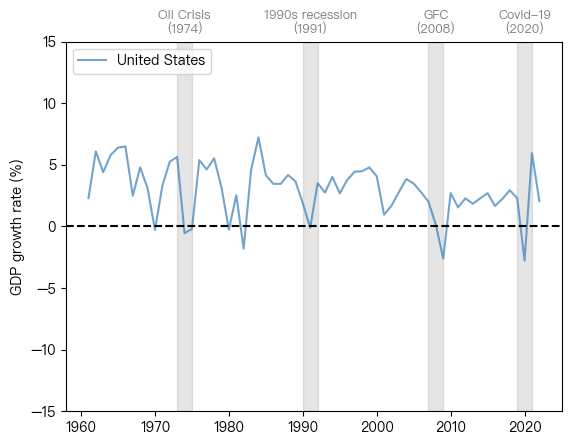

In [38]:
# 美国
fig, ax = plt.subplots()

country = 'United States'
ylabel = 'GDP growth rate (%)'
plot_series(gdp_growth, country, 
            ylabel, 0.1, ax, 
            g_params, b_params, t_params)
plt.show()

In [23]:
# 失业率分析
start_date = datetime.datetime(1929, 1, 1)
end_date = datetime.datetime(1942, 6, 1)
unrate_history = web.DataReader('M0892AUSM156SNBR', 'fred', start_date, end_date)
unrate_history.rename(columns={'M0892AUSM156SNBR': 'UNRATE'}, inplace=True)

start_date = datetime.datetime(1948, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
unrate = web.DataReader('UNRATE', 'fred', start_date, end_date)

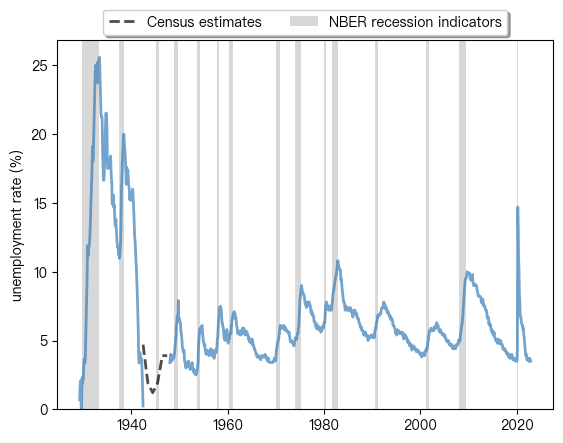

In [24]:
# 美国长期失业率分析图
# We use the census bureau's estimate for the unemployment rate 
# between 1942 and 1948
years = [datetime.datetime(year, 6, 1) for year in range(1942, 1948)]
unrate_census = [4.7, 1.9, 1.2, 1.9, 3.9, 3.9]

unrate_census = {'DATE': years, 'UNRATE': unrate_census}
unrate_census = pd.DataFrame(unrate_census)
unrate_census.set_index('DATE', inplace=True)

# Obtain the NBER-defined recession periods
start_date = datetime.datetime(1929, 1, 1)
end_date = datetime.datetime(2022, 12, 31)

nber = web.DataReader('USREC', 'fred', start_date, end_date)

fig, ax = plt.subplots()

ax.plot(unrate_history, **g_params, 
        color='#377eb8', 
        linestyle='-', linewidth=2)
ax.plot(unrate_census, **g_params, 
        color='black', linestyle='--', 
        label='Census estimates', linewidth=2)
ax.plot(unrate, **g_params, color='#377eb8', 
        linestyle='-', linewidth=2)

# Draw gray boxes according to NBER recession indicators
ax.fill_between(nber.index, 0, 1,
                where=nber['USREC']==1, 
                color='grey', edgecolor='none',
                alpha=0.3, 
                transform=ax.get_xaxis_transform(), 
                label='NBER recession indicators')
ax.set_ylim([0, ax.get_ylim()[1]])
ax.legend(loc='upper center', 
          bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True)
ax.set_ylabel('unemployment rate (%)')

plt.show()

In [25]:
# 绘制多个国家
def plot_comparison(data, countries, 
                        ylabel, txt_pos, y_lim, ax, 
                        g_params, b_params, t_params, 
                        baseline=0):
    """
    Plot multiple series on the same graph

    Parameters
    ----------
    data : pd.DataFrame
        Data to plot
    countries : list
        List of countries to plot
    ylabel : str
        Label of the y-axis
    txt_pos : float
        Position of the recession labels
    y_lim : float
        Limit of the y-axis
    ax : matplotlib.axes._subplots.AxesSubplot
        Axes to plot on
    g_params : dict
        Parameters for the lines
    b_params : dict
        Parameters for the recession highlights
    t_params : dict
        Parameters for the recession labels
    baseline : float, optional
        Dashed baseline on the plot, by default 0
    
    Returns
    -------
    ax : matplotlib.axes.Axes
        Axes with the plot.
    """
    
    # Allow the function to go through more than one series
    for country in countries:
        ax.plot(data.loc[country], label=country, **g_params)
    
    # Highlight recessions
    ax.axvspan(1973, 1975, **b_params)
    ax.axvspan(1990, 1992, **b_params)
    ax.axvspan(2007, 2009, **b_params)
    ax.axvspan(2019, 2021, **b_params)
    if y_lim != None:
        ax.set_ylim([-y_lim, y_lim])
    ylim = ax.get_ylim()[1]
    ax.text(1974, ylim + ylim*txt_pos, 
            'Oil Crisis\n(1974)', **t_params) 
    ax.text(1991, ylim + ylim*txt_pos, 
            '1990s recession\n(1991)', **t_params) 
    ax.text(2008, ylim + ylim*txt_pos, 
            'GFC\n(2008)', **t_params) 
    ax.text(2020, ylim + ylim*txt_pos, 
            'Covid-19\n(2020)', **t_params) 
    if baseline != None:
        ax.hlines(y=baseline, xmin=ax.get_xlim()[0], 
                  xmax=ax.get_xlim()[1], color='black', 
                  linestyle='--')
    ax.set_ylabel(ylabel)
    ax.legend()
    return ax

# Define graphical parameters 
g_params = {'alpha': 0.7}
b_params = {'color':'grey', 'alpha': 0.2}
t_params = {'color':'grey', 'fontsize': 9, 'va':'center', 'ha':'center'}

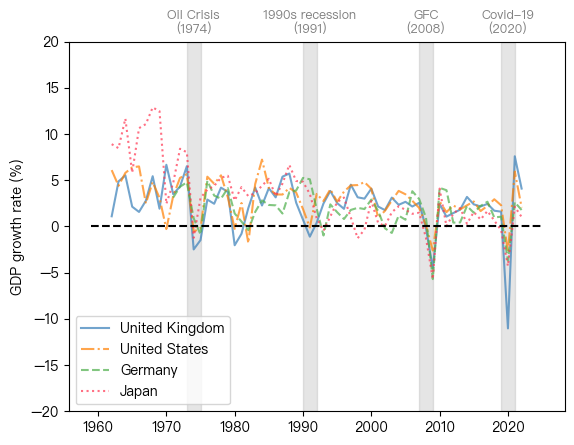

In [26]:
# Obtain GDP growth rate for a list of countries
gdp_growth = wb.data.DataFrame('NY.GDP.MKTP.KD.ZG',
            ['CHN', 'USA', 'DEU', 'BRA', 'ARG', 'GBR', 'JPN', 'MEX'], 
            labels=True)
gdp_growth = gdp_growth.set_index('Country')
gdp_growth.columns = gdp_growth.columns.str.replace('YR', '').astype(int)

# 发达经济体
fig, ax = plt.subplots()
countries = ['United Kingdom', 'United States', 'Germany', 'Japan']
ylabel = 'GDP growth rate (%)'
plot_comparison(gdp_growth.loc[countries, 1962:], 
                countries, ylabel,
                0.1, 20, ax, 
                g_params, b_params, t_params)
plt.show()

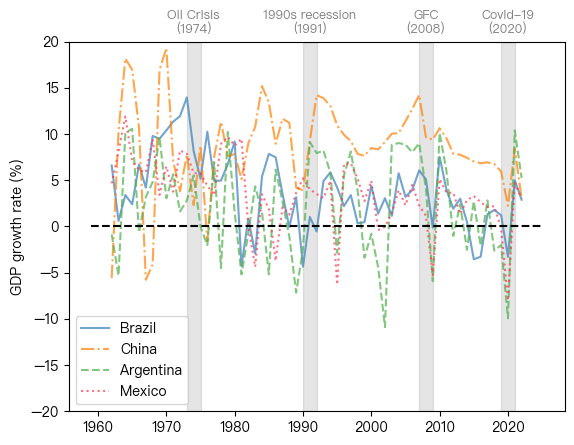

In [27]:
# 发展中经济体
fig, ax = plt.subplots()
countries = ['Brazil', 'China', 'Argentina', 'Mexico']
plot_comparison(gdp_growth.loc[countries, 1962:], 
                countries, ylabel, 
                0.1, 20, ax, 
                g_params, b_params, t_params)
plt.show()

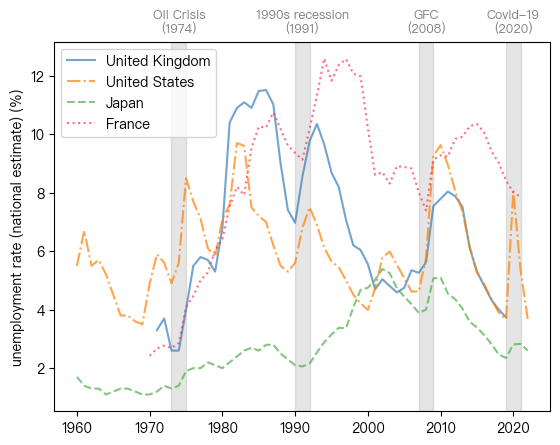

In [28]:
# 失业率和劳动力市场状况
unempl_rate = wb.data.DataFrame('SL.UEM.TOTL.NE.ZS',
    ['USA', 'FRA', 'GBR', 'JPN'], labels=True)
unempl_rate = unempl_rate.set_index('Country')
unempl_rate.columns = unempl_rate.columns.str.replace('YR', '').astype(int)

fig, ax = plt.subplots()

countries = ['United Kingdom', 'United States', 'Japan', 'France']
ylabel = 'unemployment rate (national estimate) (%)'
plot_comparison(unempl_rate, countries, 
                ylabel, 0.05, None, ax, g_params, 
                b_params, t_params, baseline=None)
plt.show()

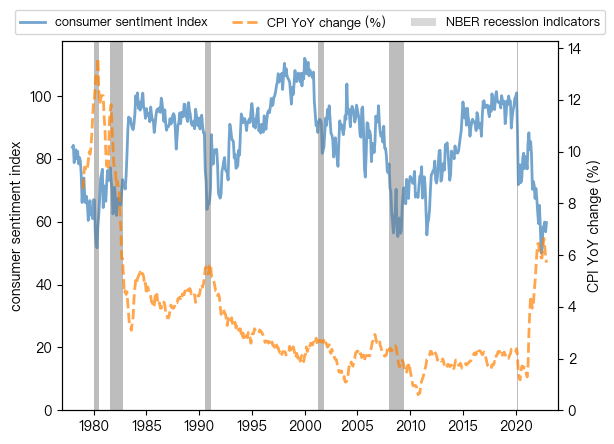

In [29]:
# 消费分析
start_date = datetime.datetime(1978, 1, 1)
end_date = datetime.datetime(2022, 12, 31)

# Limit the plot to a specific range
start_date_graph = datetime.datetime(1977, 1, 1)
end_date_graph = datetime.datetime(2023, 12, 31)

nber = web.DataReader('USREC', 'fred', start_date, end_date)
consumer_confidence = web.DataReader('UMCSENT', 'fred', 
                                start_date, end_date)

fig, ax = plt.subplots()
ax.plot(consumer_confidence, **g_params, 
        color='#377eb8', linestyle='-', 
        linewidth=2)
ax.fill_between(nber.index, 0, 1, 
            where=nber['USREC']==1, 
            color='grey', edgecolor='none',
            alpha=0.3, 
            transform=ax.get_xaxis_transform(), 
            label='NBER recession indicators')
ax.set_ylim([0, ax.get_ylim()[1]])
ax.set_ylabel('consumer sentiment index')

# Plot CPI on another y-axis
ax_t = ax.twinx()
inflation = web.DataReader('CPILFESL', 'fred', 
                start_date, end_date).pct_change(12)*100

# Add CPI on the legend without drawing the line again
ax_t.plot(2020, 0, **g_params, linestyle='-', 
          linewidth=2, label='consumer sentiment index')
ax_t.plot(inflation, **g_params, 
          color='#ff7f00', linestyle='--', 
          linewidth=2, label='CPI YoY change (%)')

ax_t.fill_between(nber.index, 0, 1,
                  where=nber['USREC']==1, 
                  color='grey', edgecolor='none',
                  alpha=0.3, 
                  transform=ax.get_xaxis_transform(), 
                  label='NBER recession indicators')
ax_t.set_ylim([0, ax_t.get_ylim()[1]])
ax_t.set_xlim([start_date_graph, end_date_graph])
ax_t.legend(loc='upper center',
            bbox_to_anchor=(0.5, 1.1),
            ncol=3, fontsize=9)
ax_t.set_ylabel('CPI YoY change (%)')
plt.show()

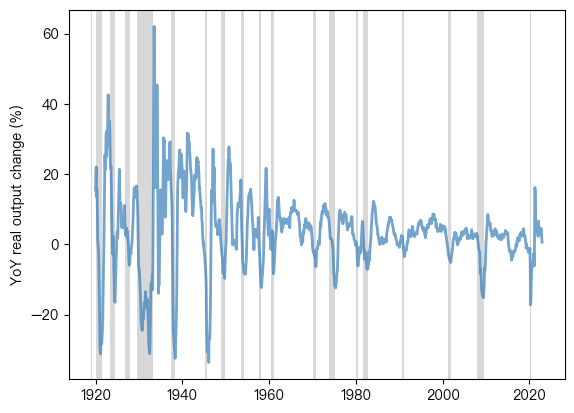

In [30]:
# 生产力分析
start_date = datetime.datetime(1919, 1, 1)
end_date = datetime.datetime(2022, 12, 31)

nber = web.DataReader('USREC', 'fred', 
                    start_date, end_date)
consumer_confidence = web.DataReader('INDPRO', 'fred', 
                    start_date, end_date).pct_change(12)*100

fig, ax = plt.subplots()
ax.plot(consumer_confidence, **g_params, 
        color='#377eb8', linestyle='-', 
        linewidth=2, label='Consumer price index')
ax.fill_between(nber.index, 0, 1,
                where=nber['USREC']==1, 
                color='grey', edgecolor='none',
                alpha=0.3, 
                transform=ax.get_xaxis_transform(), 
                label='NBER recession indicators')
ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1]])
ax.set_ylabel('YoY real output change (%)')
plt.show()

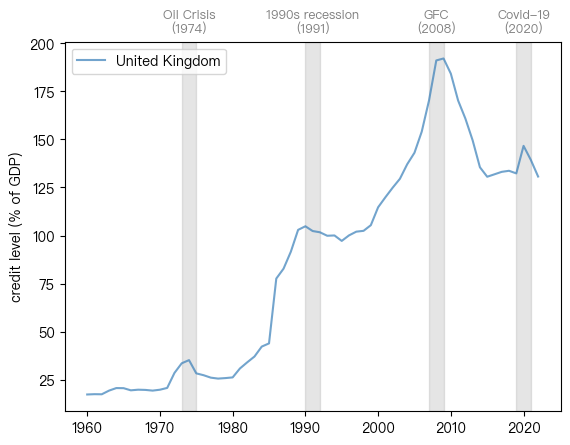

In [31]:
# 信贷分析
private_credit = wb.data.DataFrame('FS.AST.PRVT.GD.ZS', 
                ['GBR'], labels=True)
private_credit = private_credit.set_index('Country')
private_credit.columns = private_credit.columns.str.replace('YR', '').astype(int)

fig, ax = plt.subplots()

countries = 'United Kingdom'
ylabel = 'credit level (% of GDP)'
ax = plot_series(private_credit, countries, 
                 ylabel, 0.05, ax, g_params, b_params, 
                 t_params, ylim=None, baseline=None)
plt.show()